# Diffusion in volumes and on surfaces

<div class="admonition note">
**Topics**: Volume diffusion, Surface diffusion, Diffusion boundaries, Tetrahedral mesh loading, Geometrical elements manipulation, Spatial data saving, Metadata saving.
</div>

The corresponding python script: [STEPS_Tutorial_Diffusion.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_Diffusion.py)

This chapter introduces how to model and simulate diffusion systems.
First we will look at how to describe the diffusive motion of molecules
by using object of class [steps.model.Diffusion](API_model.rst#steps.API_2.model.Diffusion), then how to import
a tetrahedral mesh by using the [steps.geom.TetMesh](API_geom.rst#steps.API_2.geom.TetMesh) class, then how to restrict the diffusion of species with diffusion boundaries, and finally how to use the `'Tetexact'` solver in a simulation. 

We will also familiarize ourselves with the manipulation of geometrical elements (tetrahedrons, triangles, etc.) and we will see how to save data in a 3D simulation and how to use [matplotlib](https://matplotlib.org/) to visualize it.

## Preliminary explanations

### Diffusion in volumes

In reaction-diffusion simulations, each individual tetrahedron behaves like a well-mixed compartment where reactions can take place. Diffusive flux between tetrahedral elements is represented by a series of first-order reactions with rate constants derived from the local geometry and the diffusion constant parameter. Thus, STEPS can simulate full reaction-diffusion systems in complex geometries, but in this introduction we will start with a simple diffusion system.

We will simulate diffusion of a molecular species from a point source
in an infinite volume, a problem chosen for simplicity and with a known analytical
solution we can compare to our STEPS simulation results. As the volume in STEPS
must of course be finite we will create a large mesh, inject our
molecules into the central tetrahedron (as there is no concept of a point
source in STEPS) and compare our results to the analytical solution up to a
time when there are zero or an insignificant number of boundary events.

To compare our mean results in STEPS to an analytical solution we must solve
the diffusion equation for one spatial dimension, the radial distance from the
point source. The problem is simplified to one dimension because the symmetry
of the problem dictates that, in the deterministic limit, the concentration at any given radial distance r
from the point source will be equal at all points in space forming a
two-dimensional “shell” at that *r*.

If all molecules exist at a single point at time 0, within an infinite boundary,
the analytical solution is (see e.g. Crank, J. (1975) The Mathematics of Diffusion.
Oxford: Clarendon Press):

\begin{equation}
C(r,t)=\frac{N}{8(\pi Dt)^{3/2}}\exp\left(\frac{-r^{2}}{4Dt}\right)
\end{equation}

where *C* is the concentration (if length units are meters the units of C are number of molecules/ $m^{\text{3}}$)
at radial distance *r*  from source at time *t*, *N* is the total number of injected
molecules and *D* is the diffusion constant (in units $m^{\text{2}}/s$) .

### Diffusion on surfaces

In STEPS, surface diffusion means movement of molecules between triangle elements within a patch and is used to model e.g. mobility of surface receptors
within membranes.

In practice, simulating diffusion in surfaces is analogous to simulating diffusion in volumes,
replacing volume system with surface system and compartment with patch. Here, we will demonstrate the simple case of free diffusion from
a source on a large circular surface, which is somewhat analogous to free diffusion in a volume. In order to have both types of diffusion in the same mesh, we will use a cylindrical mesh
With the top circular face being used for surface diffusion.

We will similarly compare STEPS results with an analytical solution. In the deterministic limit, C, the number of diffusing molecules per unit area, at a distance
r from a point source on an infinite plane surface
at time *t* is (Crank, J. (1975) The Mathematics of Diffusion. Oxford: Clarendon Press):

\begin{equation}
C(r,t)=\frac{N}{4\pi Dt}\exp\left(\frac{-r^{2}}{4Dt}\right)
\end{equation}

where *N* is the total number of injected molecules and *D* is the diffusion constant (in units $m^{\text{2}}/s$ if length units are metres and time units seconds).

### Diffusion boundaries

In some systems it may be a convenient simulation feature to be able to localize certain chemical species in one particular region of a volume without diffusion to neighboring regions even if they are not separated by a physical boundary. For example, in some biological systems certain proteins may exist only in local regions and though the structural features are simplified in a model the proteins are assumed to diffuse in a local region to meet and react with each other. So it is sometimes important to restrict the diffusional space of some proteins and not others from a biologically feasible perspective. Similarly, it may be convenient to separate a large simulation volume into a number of compartments that are not physically separated by a membrane and so are connected to other compartments by chemical diffusion. Such an approach allows for different biochemical behavior in different regions of the volume to be specified.

A volume diffusion boundary is described by a collection of triangles. These triangles must form some or all of the connection between two (and only two) compartments, and none of the triangles may already be described as part of a patch. It is not possible for two compartments to be connected in the same area by a Patch and a Diffusion Boundary since a Patch is intended to model a membrane and a Diffusion Boundary is just some internal area within a volume that may block diffusion, and it would be unrealistic to allow surface reactions and free diffusion to occur in the same area. Once a Diffusion Boundary is in place the modeler may specify which chemical species (if any) may freely diffuse through the boundary.

A surface diffusion boundary if very similar to a volume diffusion boundary, except that it is decribed by a collection of bars (i.e. segments) that lie at the border between two patches.

## Model declaration

Let us first declare a few parameters alongside the necessary package imports and model creation:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

import numpy as np

# Diffusion constants (m^2/s)
DCST  = 20e-12
SDCST = 15e-12

# Numbers of molecules injected in center
NINJECT  = 10000
SNINJECT = 10000

# SImulation end time
ENDT = 0.1

# Number of runs
NBRUNS = 100

# Number of elements to sample data from
NSAMPLES = 2000

mdl = Model()
r = ReactionManager()

By keeping our simulation parameters grouped together at the beginning of a Python script we would make it easy to locate and change them if we wished to. We use capital letters for the variables here so it is clear later in the script that they are constants.

Since we will not consider any reactions in this chapter, the model building is quite straightforward:

In [2]:
with mdl:
    X, Y = Species.Create()
    vsys = VolumeSystem.Create()
    ssys = SurfaceSystem.Create()
    with vsys:
        Diffusion(X, DCST)
        
    with ssys:
        Diffusion(Y, SDCST)

We create two species `X` and `Y` that will respectively diffuse in a volume and on a surface. Like reactions, diffusion rules need to be declared inside a `VolumeSystem` or a `SurfaceSystem`. We thus create both and then simply declare the diffusion rules with:
```python
Diffusion(X, DCST) 
```
Which states that species `X` will diffuse with diffusion constant `DCST` (in $m^2/s$) in the volume system `vsys`. The same applies for surface diffusion, replacing `X` by `Y` and `DCST` by `SDCST` (which is also in $m^2/s$). Here we do not provide any name to the diffusion rule because we will not modify any of its properties during the simulation. If we did need to modify it, we would have given it a name using the automatic naming syntax:
```python
volDiff = Diffusion.Create(X, DCST)
```
We would then be able to access its diffusion constant during simulation with e.g. `sim.comp.volDiff.D`.

## Geometry declaration

We now move on to describing our geometry. This is the section that stands out as very different to our previous well-mixed simulations. Instead of using the `Geometry` class, we will use the `TetMesh` class.
The methods we provide for describing mesh-based geometry in STEPS give tools for importing meshes from some powerful mesh-generation packages, and methods for initialising and controlling your simulation conditions which are beyond the ground covered in this chapter.
A full list of tetrahedral mesh methods is available in [steps.geom](API_geom.rst).

The `TetMesh` class provides a number of importing methods that support file formats such as [TetGen](http://wias-berlin.de/software/index.jsp?id=TetGen) ([TetMesh.LoadTetGen](API_geom.rst#steps.API_2.geom.TetMesh.LoadTetGen)), [VTK](https://vtk.org/) ([TetMesh.LoadVTK](API_geom.rst#steps.API_2.geom.TetMesh.LoadVTK)), [Gmsh](https://gmsh.info/) ([TetMesh.LoadGmsh](API_geom.rst#steps.API_2.geom.TetMesh.LoadGmsh)), and Abaqus ([TetMesh.LoadAbaqus](API_geom.rst#steps.API_2.geom.TetMesh.LoadAbaqus)).
Mesh generators like [TetGen](http://wias-berlin.de/software/index.jsp?id=TetGen), [CUBIT](http://cubit.sandia.gov/) and
[NETGEN](https://ngsolve.org/) can all export files readable by STEPS, along with any others supporting the Abaqus output format.

Let us now load our mesh in STEPS:

In [3]:
mesh = TetMesh.LoadAbaqus('meshes/cylinder_86k.inp', scale=1e-6)

We load the tetrahedral mesh from an Abaqus file with a scale parameter of `1e-6` to transform distances from μm to m. 

The information passed on from the mesh generators is often only very basic information about the mesh and STEPS must find a vast amount of information to pass on to the reaction-diffusion solver internally. This can be time-consuming for large meshes, however this process only needs to be performed once. With the [Save](API_geom.rst#steps.API_2.geom.TetMesh.Save) method the
mesh is saved with basic information in an XML file, with an accompanying ASCII file containing all the extra information STEPS computed when importing the mesh. 

To save the mesh in STEPS format, one would thus write:
```python
mesh.Save('meshes/cylinder_86k')
```

After the mesh has been saved to STEPS format, it can then be imported with the [TetMesh.Load](API_geom.rst#steps.API_2.geom.TetMesh.Load) method, which will only take a few seconds or minutes to load even very large meshes:
```python
mesh = TetMesh.Load('meshes/cylinder_86k')
```

We then use `mesh` as a context manager, in the same way as `geom` in the previous chapters. Everything declared in the `with mesh:` block will thus implicitely be declared for `mesh`:

In [4]:
with mesh:
    topTets = TetList(tet for tet in mesh.tets if tet.center.z > 0)
    
    comp1 = Compartment.Create(topTets, vsys)
    comp2 = Compartment.Create(mesh.tets - comp1.tets, vsys)
    
    diffb = DiffBoundary.Create(comp1.surface & comp2.surface)
    
    patchSurf = TriList(tri for tri in mesh.surface if tri.center.z == mesh.bbox.max.z)
    
    leftTris = TriList(tri for tri in patchSurf if tri.center.x > 0)
    
    patch1 = Patch.Create(leftTris, comp1, comp2, ssys)
    patch2 = Patch.Create(patchSurf - leftTris, comp1, comp2, ssys)
    
    sdiffb = SDiffBoundary.Create(patch1.edges & patch2.edges, patch1, patch2)

### Geometrical elements

Many new classes are used in this block, we will thus go through it by introducing the different ways to manipulate geometrical data. Tetrahedral meshes hold 4 types of elements:

Full name | Dimension | Access  | List type  | Element Type
:--              |:--| :--          | :--        | :--
**Vert**ex       | 0 | `mesh.verts` | `VertList` | `VertReference`
**Bar**          | 1 | `mesh.bars`  | `BarList`  | `BarReference`
**Tri**angle     | 2 | `mesh.tris`  | `TriList`  | `TriReference`
**Tet**rahedron  | 3 | `mesh.tets`  | `TetList`  | `TetReference`

The bold part of the name gives the short name for each element type. When `mesh.tets` is called, it returns an object of type `TetList` which can be used in the same way as a python list: individual elements can be accessed with square brackets (`mesh.tets[0]` returns the first tetrahedron in the mesh) and elements can be added by calling `append`:
```python
tetLst = TetList()
tetLst.append(mesh.tets[0])
```
The above code first creates an empty `TetList` to which we then add the first tetrahedron of the mesh. Note that, as long as we are inside a `with mesh:` block, this list is implicitely associated to `mesh`. 
Alternatively, to create a list from a single element, we can use:
```python
tetLst = mesh.tets[0].toList()
```

### Geometrical list manipulation

The mesh that we loaded is a cylinder centered on (0, 0, 0) with 10μm radius and 20μm height. We first want to split the volume in two compartments along the z = 0 plane. In order to get the tetrahedrons composing the top compartment, we use a [python generator expression](https://docs.python.org/3/reference/expressions.html#generator-expressions) to initialize a `TetList`:
```python
topTets  = TetList(tet for tet in mesh.tets if tet.center.z > 0)
```
`topTets` will then contain all tetrahedrons whose barycenters are above the z = 0 plane. `tet.center` returns the barycenter of tetrahedron `tet`, it can be used directly as a numpy array of length 3 or individual coordinates can be accessed with `.x`, `.y` or `.z`.

Note that if we were not in a `with mesh:` block, we would have to explicitely specify which mesh the list is associated with, either by using the `mesh` keyword parameter:
```python
topTets = TetList((tet for tet in mesh.tets if tet.center.z > 0), mesh=mesh)
```
or by giving a non-empty python list of `TetReference` instead of a generator expression:
```python
topTets = TetList([tet for tet in mesh.tets if tet.center.z > 0])
```

### Compartments

A tetrahedral-mesh compartment is comprised of a group of tetrahedrons, so we must supply the object constructor with the enclosed tetrahedrons in a `TetList`.
A mesh can be separated into as many compartments as the user wishes, though compartments should usually be separated physically by a boundary (i.e. by a membrane) as *there is no implicit diffusion between compartments in STEPS, unless connected by a Diffusion Boundary (see later in this chapter)*.

Back to our code, we then declare a compartment with the `Compartment` class:
```python
comp1 = Compartment.Create(topTets, vsys)
```
A tetrahedral compartment is created with the same `Compartment` class that we used earlier for well-mixed simulations but the first parameter needs to be a list of tetrahedrons. We cannot provide a volume but we can tie the compartment to a `VolumeSystem`. If no `VolumeSystem` is provided at creation, one can be added with the `addSystem` method, like we saw earlier.
The second compartment should be created from the remaining tetrahedrons, we can thus write:
```python
comp2 = Compartment.Create(mesh.tets - comp1.tets, vsys)
```
We can use the subtraction operator with `TetList`s, `mesh.tets - comp1.tets` thus returns a `TetList` of tetrahedrons that are in the mesh but are not part of `comp1`. Geometrical element lists support operations using the conventions from [python sequences](https://docs.python.org/3.8/library/stdtypes.html#common-sequence-operations):

Syntax | Description
:-- | :--
`elem in lst` | Return `True` if `elem` is in `lst`
`lst.append(elem)` | Append `elem` to `lst`
`lst1 + lst2` | Concatenation of `lst1` and `lst2`
`lst[i]` | `i`th element in `lst`
`lst[i:j]` | Elements between the `i`th inclusive and the `j`th noninclusive
`len(lst)` | Number of elements in `lst` 
`lst.index(elem)` | Index of `elem` in `lst` 
`lst.indices` | List of mesh indices of the elements

Some properties and methods are only available for lists of tetrahedrons or triangles:

List type | Property | Description
:-- | :-- | :--
`TetList`, `TriList`, `BarList` | `verts` | `VertList` of all vertices composing the elements in the list
`TetList`, `TriList` | `bars` | `BarList` of all bars composing the elements in the list
`TetList` | `tris` | `TriList` of all triangles composing the tetrahedrons in the list
`TetList` | `surface` | `TriList` of triangles that are on the surface of the TetList
`TetList` | `Vol` | Summed volume of all tetrahedrons
`TriList` | `Area` | Summed area of all triangles

In addition, geometrical element lists also support operations using the conventions from [python set](https://docs.python.org/3.8/library/stdtypes.html#set):

| Syntax | Name | Description | Equivalent list
| :-- | :-: | :-- | :--
| `lst1 - lst2` | Difference | Elements that are in `lst1` but not in `lst2` | `[e for e in lst1 if e not in lst2]`
| `lst1 & lst2` | Intersection | Elements that are in both `lst1` and `lst2` | `[e for e in lst1 if e in lst2]`
| `lst1 | lst2` | Union | Elements that are in `lst1` or `lst2` | `lst1 + (lst2 - lst1)`
| `lst1 ^ lst2` | Symetric difference | Elements that are in `lst1` or `lst2` but not in both | `(lst1 - lst2) + (lst2 - lst1)`

Note that for the first table of operations, geometrical element lists behave like python `list`s in the sense that they have a specific ordering and allow duplicates. For the second table that implements `set` operations, the order of elements is conserved, but duplicates might not all be conserved, see the "Equivalent list" column for the behavior of each operation.

### Patches and diffusion boundaries

In this section we will manipulate triangle lists to create diffusion boundaries and patches. It is important to realise that triangles appear internally in tetrahedral meshes, not only on the exterior surface, and internal patches comprising a collection of interior triangles (or even a combination of interior and exterior triangles) are supported in STEPS. This is essential to allow multiple compartment modelling by one tetrahedral mesh. For example, if a mesh represented a section of a cell separated into cytosol and intracellular organelle compartments, then the collection of triangles on the exterior surface might represent the cell membrane, with collections of interior triangles representing organelle membranes.

Going back to our main example, we first want to create a diffusion boundary between `comp1` and `comp2`. We thus need to find the triangles that are at the boundary between the two compartments. To do so, we use the `surface` property of `Compartment`s that returns a `TriList` of triangles on the surface of each of the compartments and we then compute the intersection of both surfaces:
```python
diffb = DiffBoundary.Create(comp1.surface & comp2.surface)
```
Note that the `surface` property is also available for `TetList`s, we could have written `comp1.tets.surface & comp2.tets.surface` instead. 

We then want to create patches for surface diffusion on top of the cylinder. We select the corresponding triangles with:
```python
patchSurf = TriList(tri for tri in mesh.surface if tri.center.z == mesh.bbox.max.z)
```
`mesh.surface` returns the triangles on the surface of the cylinder and we further restrict our selection by only retaining these triangles whose barycenter is at a height that corresponds to the top of the mesh. `mesh.bbox` represents the bounding box around the mesh and has two properties: `min` and `max`. Each of these properties can be treated as a numpy array or alternatively, individual coordinates can be accessed in the same way as for barycenters.

We then want to split this circular face in two patches:
```python
leftTris = TriList(tri for tri in patchSurf if tri.center.x > 0)

patch1 = Patch.Create(leftTris, comp1, comp2, ssys)
patch2 = Patch.Create(patchSurf - leftTris, comp1, comp2, ssys)
```
We first create a `TriList` containing only triangles whose barycenter is on the positive side of the x axis. We then create a `Patch` object; since we are using a tetrahedral mesh, the patch is composed of triangles and thus takes a list of triangles as first parameter. The remaining parameters follow the same order as for well-mixed geometries: inner compartment, outer compartment, and optionally a `SurfaceSystem`. Note that, like for `Compartment` in meshes, one cannot set the area of a `Patch` in a mesh.

Finally, we create the surface diffusion boundary between these two patches with:
```python
sdiffb = SDiffBoundary.Create(patch1.edges & patch2.edges, patch1, patch2)
```
`patch1.edges` returns a `BarList` that corresponds to the outer edges of triangles from `patch1`. Like for `TetList`s, the `edges` property also works on `TriList`s and we could have written `patch1.tris.edges & patch2.tris.edges` instead. In addition to the list of bars that compose the boundary, we also need to specify the two patches on either side of the boundary. The reason for this is that any given bar within the Surface Diffusion Boundary can be connected to any number of triangles (not just 2) which can belong to more than 2 Patches; providing this information to the Surface Diffusion Boundary constructor thus avoids ambiguity.

We now have setup all the geometrical elements in our example but we still need to perform some geometrical operations that will be useful during simulation and for data recording. We first find the central tetrahedron as well as the center triangle of the top face:

In [5]:
centerTet = mesh.tets[0, 0, 0]
topTri = min(patchSurf, key=lambda tri: np.linalg.norm(tri.center))

For `TetList` specifically, it is possible to use the square brackets syntax with a 3D position instead of an index. `mesh.tets[0, 0, 0]` thus returns the tetrahedron that includes the (x = 0, y = 0, z = 0) point. If no such tetrahedron exists, an exception is raised. 

For finding the center triangle of the top face, we use the standard python function [min](https://docs.python.org/3.8/library/functions.html#min) with a custom ordering function ('key' parameter). The ordering function is given as a [lambda expression](https://docs.python.org/3/tutorial/controlflow.html?highlight=lambda#lambda-expressions), it takes a triangle and returns the distance between this triangle's barycenter and the origin (0, 0, 0). The min function thus returns the triangle whose barycenter is closest to (0, 0, 0) among the triangles of the top face, i.e. the center triangle.

### Geometrical element properties

As we saw earlier, instead of describing geometrical elements only by their index in the mesh, they are all wrapped by classes that make it possible to access their properties easily. In our example, `centerTet` is a `TetReference` to the central tetrahedron and `topTri` is a `TriReference` to the center top triangle. Here we give an exhaustive list of available properties:

Element(s) | Property | Description
:-- | :-- | :--
Tet, Tri, Bar, Vert | `idx` | Index of the element in the mesh
Tet, Tri, Bar | `verts` | `VertList` of all the vertices of the element
Tet, Tri, Bar | `center` | Barycenter of the element
Tet | `neighbs` | `TetList` of all tetrahedrons that share a face with the tetrahedron
Tet | `faces` | `TriList` of the triangles composing the tetrahedron
Tet | `comp` | `Compartment` associated with the tetrahedron or `None`
Tet | `Vol` | Volume of the tetrahedron in $m^3$
Tet | `qualityRER` | Radius-edge-ratio (a quality measurement) of tetrahedron
Tri | `tetNeighbs` | `TetList` of tetrahedrons on either sides of the triangle
Tri | `bars` | `BarList` of the 3 bars of the triangle
Tri | `patch` | `Patch` associated to triangle or `None`
Tri | `Area` | Area of the triangle in $m^2$
Tri | `norm` | Normal vector of the triangle
Vert | `x`, `y`, `z` | Coordinates of the vertex

We will simulate volume diffusion from the center of the mesh and surface diffusion on the top face from its center. For the surface diffusion, the total number of triangles in the top face is not too high so it will be possible to save the counts of `Species` `Y` for all of them. We will however not be able to do the same thing for volume diffusion, there are too many tetrahedrons and saving the counts of `Species` `X` for each of them would be too costly. Instead we randomly select `NSAMPLES` tetrahedrons to record from:

In [6]:
randTets = centerTet.neighbs
while len(randTets) < NSAMPLES:
    pos = np.random.random(3) * (mesh.bbox.max - mesh.bbox.min) + mesh.bbox.min
    try:
        tet = mesh.tets[pos]
        if tet not in randTets:
            randTets.append(tet)
    except KeyError:
        continue

We first initialize the `randTets` list with the immediate neighbors of `centerTet`. Note that if we wanted to initialize `randTets` to an empty list, we could have written:
```python
randTets = TetList([], mesh=mesh)
```
Since we are not in a `with mesh:` block, we need to specify which mesh the `TetList` is associated to. In our example, `centerTet` is already associated with `mesh`, so `centerTet.neighbs` is automatically associated with `mesh`.
While the `randTets` list has less than `NSAMPLE` elements, we sample a 3D point within the bounding box of the mesh and try to find the corresponding tetrahedron.
Sampling a point within the bounding box is done with:
```python
pos = np.random.random(3) * (mesh.bbox.max - mesh.bbox.min) + mesh.bbox.min
```
`np.random.random(3)` returns a numpy array of length 3 in which each coordinate is uniformly sampled between 0 and 1. `(mesh.bbox.max - mesh.bbox.min)` is the vector corresponding to the diagonal of the bounding box; by multiplying it with our random vector using the element-wise product, we get a random vector that corresponds to a random point within the bounding box, assuming the inferior point of the bounding box is (0, 0, 0). We then shift this point by adding `mesh.bbox.min` so that the origin corresponds to the actual inferior point of the bounding box.
We then try to access the corresponding tetrahedron with `mesh.tets[pos]`. If no tetrahedron corresponds to this points, an exception is raised (this can happen because there is space within the bounding box that is not inside the cylinder). We thus wrap the code in a [try-except block](https://docs.python.org/3/tutorial/errors.html#handling-exceptions); if the `tet = mesh.tets[pos]` line does not raise an exception, we add the tetrahedron to the list if it is not already in. Otherwise, if a `KeyError` exception is raised (i.e. no tetrahedron corresponds to this point), we [continue](https://docs.python.org/3/tutorial/controlflow.html#break-and-continue-statements-and-else-clauses-on-loops).

Finally, we would like to be able to visualize the concentration of `Species` `X` in a 2D slice of the mesh. Instead of getting a truly planar slice, which would be relatively complicated, we will approximate it by first finding all triangles close to the x = 0 plane. We proceeed in the same way as we did for finding the diffusion boundary earlier:

In [7]:
leftTets = TetList([tet for tet in mesh.tets if tet.center.x > 0])
diffSurf = leftTets.surface & (mesh.tets - leftTets).surface

The triangles in `diffSurf` will be our discretized approximation to the x = 0 plane. Since we want to estimate the concentration of `Species` `X` near these triangles, we next need to identify the tetrahedrons on both sides of each of them:

In [8]:
diffSlice = TetList(mesh=mesh)
triInds = []
for tri in diffSurf:
    for tet in tri.tetNeighbs:
        diffSlice.append(tet)
        triInds.append(tri.idx)

`diffSlice` is the `TetList` that we will use for saving the counts of `Species` `X` and `triInds` keeps track of the index of the associated triangle.

### Visualizing the geometry

Before creating the simulation, we will first visualize the geometry we declared to check that our code behaves as expected:

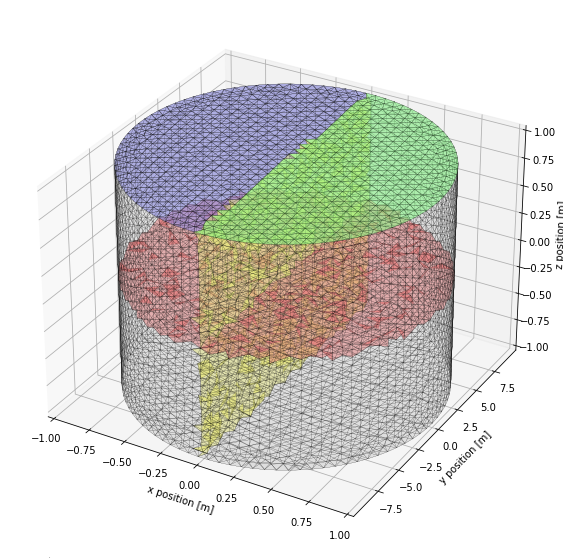

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plotTriangles(ax, tris, color):
    ax.add_collection(Poly3DCollection(
        [tri.verts for tri in tris], 
        facecolor=color, 
        edgecolors='black', 
        linewidth=0.1
    ))
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

plotTriangles(ax, mesh.surface, (0.5, 0.5, 0.5, 0.1))
plotTriangles(ax, patch1.tris,  (0.5, 1.0, 0.5, 0.5))
plotTriangles(ax, patch2.tris,  (0.5, 0.5, 1.0, 0.5))
plotTriangles(ax, [tri for tri in diffb.tris if tri.center.x > 0],  (1.0, 0.5, 0.5, 0.5))
plotTriangles(ax, [tri for tri in diffb.tris if tri.center.x <= 0],  (1.0, 0.5, 0.5, 0.5))
plotTriangles(ax, [tri for tri in diffSurf if tri.center.z > 0], (1.0, 1.0, 0.5, 0.5))
plotTriangles(ax, [tri for tri in diffSurf if tri.center.z <= 0], (1.0, 1.0, 0.5, 0.5))

ax.set_xlim(mesh.bbox.min.x, mesh.bbox.max.x)
ax.set_ylim(mesh.bbox.min.y, mesh.bbox.max.y)
ax.set_zlim(mesh.bbox.min.z, mesh.bbox.max.z)
ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_zlabel('z position [m]')
plt.show()

We use matplotlib `Poly3DCollection` to display collections of triangles. For convenience we define a small function that will plot the triangles with identical settings. The third parameter corresponds to the color of the triangles, it is a 4-tuple where each value is between 0 and 1. The first 3 represent respectively the amount of red, green and blue and the last one represents an alpha value controlling transparency.
We plot the surface of the whole mesh in grey, `patch1` in green, `patch2` in blue, the diffusion boundary between `comp1` and `comp2` in red and the `diffSurf` surface along which we will record `Species` `X` concentrations in yellow.
Note that matplotlib is not very well suited to plotting 3D data and projection issues may arise when the bounding boxes of `Poly3DCollection` overlap. To prevent this, we split the red and yellow surfaces in 2 pieces so that the overlap between their bounding boxes is minimal.

## Simulation and data saving

Having defined our model and our geometry, we then create the simulation and specify which data should be saved.

In [10]:
rng = RNG('mt19937', 512, 2903)

sim = Simulation('Tetexact', mdl, mesh, rng)

rs = ResultSelector(sim)

XConcRand   = rs.TETS(randTets).X.Conc
YCountPatch = rs.TRIS(patchSurf).Y.Count
XCountSlice = rs.TETS(diffSlice).X.Count

Model checking:
No errors were found


Since we now use a tetrahedral mesh, we need to use a different solver. The `'Tetexact'` solver builds on the `'Wmdirect'` solver
(we have used up until now) extended for diffusive fluxes between tetrahedral
elements in a mesh. Each individual tetrahedron (triangle) behaves like a well-mixed
compartment (patch) where reactions can take place. Diffusive flux between elements is represented by a series of first-order reactions
with rate constants derived from the local geometry and the diffusion
constant parameter. Thus, even though we only focus on diffusion here, this solver can be used to simulate
full reaction-diffusion systems in complex geometries.

We want to save the concentration of `X` in the random tetrahedrons we selected. The corresponding `ResultSelector` path is `rs.TETS(randTets).X.Conc`. Instead of putting a compartment or patch name in second position, we use the `TETS` function and supply our list of random tetrahedrons as parameter. The resulting `ResultSelector` `XConcRand` has the same length as the `randTets` list. The following functions are available as a substitute for a geometrical location:

Syntax | Description | Length
:-- | :-- | :-:
`TETS(lst)` | Tetrahedrons in `lst` | `len(lst)`
`TRIS(lst)` | Triangles in `lst` | `len(lst)`
`VERTS(lst)` | Vertices in `lst` | `len(lst)`
`TET(tet)` | Tetrahedron `tet` | 1
`TET(x, y, z)` | Tetrahedron at position `x`, `y`, `z` | 1
`TRI(tri)` | Triangle `tri` | 1
`VERT(vert)` | Vertex `vert` | 1

`XCountSlice` and `YCountPatch` follow the same pattern. Note that the same functions apply to simulation paths, one could set the count of `X` in all tetrahedrons in list `lst` using:
```python
sim.TETS(lst).X.Count = value
```

### Metadata saving

Since we will save the data to files and analyze the results in a separate process, we will not have access to the lists that we defined here. For `XConcRand` for example, it will not be possible to know to which tetrahedron each column of the data corresponds to. In this case, we need to store additional static data (i.e. that does not change with simulation time) about the data that we are saving. This is done with the `metaData` property of the `ResultSelectors`. In the same way as we could provide custom labels in the previous chapter, we can associate arbitrary string keys with lists that have the same length as the `ResultSelector`. For `XConcRand`, we need to know what is the distance between each tetrahedron and the centeral tetrahedron in order to plot `X` concentrations as a function of the distance to the injection site. We thus add a metadata list for keyword `'distToCenter'`:

In [11]:
XConcRand.metaData['distToCenter'] = [np.linalg.norm(tet.center) for tet in randTets]

Since `XCondRand` was declared using the `randTets` list, we use the same list so that the distances are in the same order. `np.linalg.norm()` computes the $\mathrm{L}^2$ norm of a numpy array; since we want to compute the distance between the tetrahedron center and the (0, 0, 0) point, we can directly feed `tet.center` to the `norm` function. 

We then compute the distance to center for surface diffusion in the `YCountPatch` `ResultSelector` as well as the area of each triangle:

In [12]:
YCountPatch.metaData['distToCenter'] = [
    np.linalg.norm(tri.center[:2]) for tri in patchSurf
]
YCountPatch.metaData['triArea'] = [tri.Area for tri in patchSurf]

Here we restrict `tri.center` to the x and y coordinates with `tri.center[:2]` so that we can again feed it directly to the `norm` function.

Finally, for `XCountSlice`, we need to save the index of the triangle associated to each tetrahedron as well as the volume of each tetrahedron:

In [13]:
XCountSlice.metaData['surfTri'] = triInds
XCountSlice.metaData['tetVol'] = [tet.Vol for tet in diffSlice]

We then add the `ResultSelector`s to the simulation:

In [14]:
sim.toSave(XConcRand, timePoints=[ENDT])
sim.toSave(XCountSlice, YCountPatch, dt=0.01)

We want to save data every 0.01s for `XCountSlice` and `YCountPatch` but we only need to save `XConcRand` once, at the end of the simulation. To do so, we use the `timePoints` keyword argument instead of `dt` in the `toSave` function.

## Running the simulations

Before running the simulation, we need to specify to which file each `ResultSelector` should be saved:

In [15]:
XCountSlice.toFile('XCountSlice.dat')
XConcRand.toFile('XConcRand.dat')
YCountPatch.toFile('YCountPatch.dat')

We are now ready to run our simulations. This will look quite similar to our previous code for running well-mixed simulations, but this time we are injecting molecules into and recording data from individual tetrahedrons, not the whole compartment (though this is also possible). As initial conditions, we set the number of molecules in the central tetrahedron (or triangle) at time `t = 0` to the number stored in variable `NINJECT` (or `SNINJECT`). By default all elements have their counts of all species set to zero.

During our geometry construction we already created our [steps.geom.DiffBoundary](API_geom.rst#steps.API_2.geom.DiffBoundary) object which will be included in the simulation, with the default behaviour to block diffusion between compartments `comp1` and `comp2` completely for all molecules. We now wish to allow diffusion of species 'X' through the boundary which we achieve by initializing the `DiffusionActive` property of the diffusion boundaries for species `X` to `True`.
The same remark applies to the surface diffusion of species `Y` and the surface diffusion boundary between `patch1` and `patch2`.

We now first run a series of `NBRUNS` runs in which both volume and surface diffusion are unaffected by the diffusion boundaries:

In [16]:
for r in range(NBRUNS):
    sim.newRun()
    sim.TET(centerTet).X.Count = NINJECT
    sim.TRI(topTri).Y.Count = SNINJECT
    sim.diffb.X.DiffusionActive = True
    sim.sdiffb.Y.DiffusionActive = True
    sim.run(ENDT)

We next want to activate the diffusion boundaries and prevent diffusion completely. To do so, we leave the `DiffusionActive` property of the diffusion boundaries to its default value which is `False`. Note that this property is defined in relation to a species. If we had another species `X2` undergoing volume diffusion, we could block diffusion for `X` but not for `X2` with:
```python
sim.diffb.X.DiffusionActive = False
sim.diffb.X2.DiffusionActive = True
```
Let us run these simulations with:

In [17]:
for r in range(NBRUNS):
    sim.newRun()
    sim.TET(centerTet).X.Count = NINJECT
    sim.TRI(topTri).Y.Count = SNINJECT
    sim.run(ENDT)

Finally, the last batch of runs has active diffusion across the diffusion boundaries but the diffusion constant at which this diffusion occurs is 10 times smaller than the original value. We can do this by setting the `Dcst` property of the diffusion boundaries. As for `DiffusionActive`, this property is always defined in relation with a specific species:

In [18]:
for r in range(NBRUNS):
    sim.newRun()
    sim.TET(centerTet).X.Count = NINJECT
    sim.TRI(topTri).Y.Count = SNINJECT
    sim.diffb.X.Dcst = DCST / 10
    sim.sdiffb.Y.Dcst = SDCST / 10
    sim.run(ENDT)

Note that setting the `Dcst` property to a non-zero value automatically sets `DiffusionActive` to `True`.

Simulations are now finished, we can reset the jupyter kernel with:

In [19]:
%reset -f

## Plotting the results

The corresponding python script: [STEPS_Tutorial_Diffusion_plot.py](https://github.com/CNS-OIST/STEPS_Example/tree/master/user_manual/source/API_2/scripts/STEPS_Tutorial_Diffusion_plot.py)

### Simple scatter plots

So now we come to plotting our data. Now that we have spatial information the data we wish to plot is different to our previous well-mixed simulations where we were plotting the concentration in a well-mixed compartment. We will plot the mean concentration from individual tetrahedrons (or triangles) against their radial distance from origin.

We would first like to compare the spatial profile of the concentration of species `X` at the end of the simulation to the expected theoretical profile. 

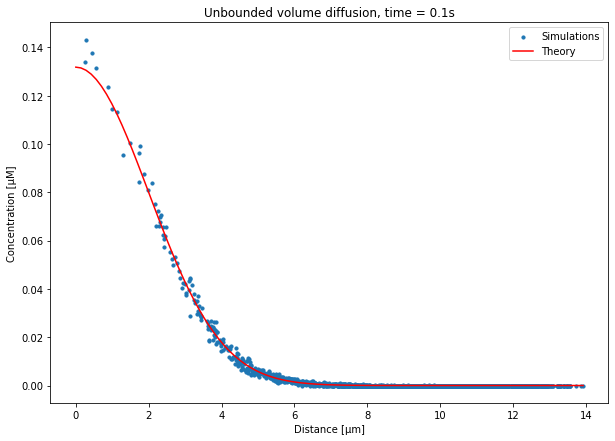

In [20]:
import steps.interface

from steps.saving import *
from steps.geom import *

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
from matplotlib import colormaps
import matplotlib.cm as cm
import numpy as np

DCST= 20e-12
SDCST = 15e-12

NINJECT = 10000
SNINJECT = 10000
NBRUNS = 100

XConcRand = ResultSelector.FromFile('XConcRand.dat')

TEND = XConcRand.time[0, -1]

plt.figure(figsize=(10, 7))

distances = XConcRand.metaData['distToCenter']
concentrs = np.mean(XConcRand.data[0:NBRUNS, -1, :], axis=0) * 1e6

plt.scatter(distances * 1e6, concentrs, s=10, label='Simulations')

def volDiffFunc(r, t):
    # Analytical value of C(r, t)
    Crt = NINJECT * np.exp(-(r**2) / (4 * DCST * t)) / (8 * (np.pi * DCST * t)**1.5)
    # Convert from number of molecules per m^3 to uM
    return Crt * (1e3 / 6.022e23)

rvals = np.linspace(0, max(distances), 100)
plt.plot(rvals * 1e6, [volDiffFunc(r, TEND) for r in rvals], 'r', label='Theory')

plt.xlabel('Distance [μm]')
plt.ylabel('Concentration [μM]')
plt.title(f'Unbounded volume diffusion, time = {TEND}s')
plt.legend()
plt.show()

Since we do not have access to previously defined variables, we first need to reimport some packages and redeclare some of the parameters. The parameters are only needed in order to compute the analytical concentration profile. We then load the `XConcRand` `ResultSelector`, as we saw in the previous chapter. Distances from the center are retrieved using:
```python
distances = XConcRand.metaData['distToCenter']
```
We then retrieve the concentration of species `X` at the end of the simulation in each tetrahedron and for each run with `XConcRand.data[0:NBRUNS, -1, :]`, compute the average across runs, and convert the units to μM. Note that we retrict the runs to `0:NBRUNS` since subsequent runs have different settings for the diffusion boundaries.

We then proceed to creating the same plot but for surface diffusion:

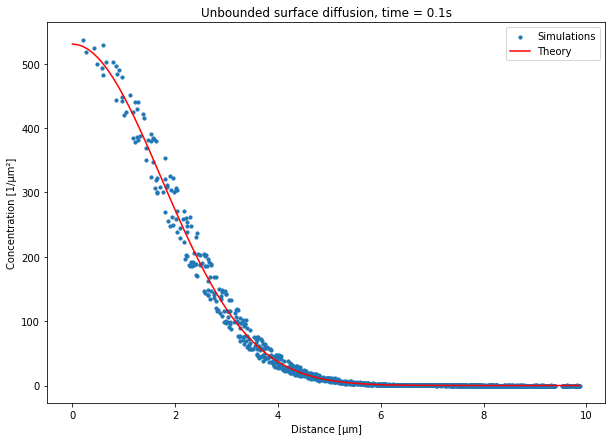

In [21]:
YCountPatch = ResultSelector.FromFile('YCountPatch.dat')

plt.figure(figsize=(10, 7))

distances  = YCountPatch.metaData['distToCenter']
counts     = np.mean(YCountPatch.data[0:NBRUNS, -1, :], axis=0)
countsPerA = counts / YCountPatch.metaData['triArea'] * 1e-12

plt.scatter(distances * 1e6, countsPerA, s=10, label='Simulations')

def surfDiffFunc(r, t):
    # Analytical value of C(r, t)
    Crt = SNINJECT * np.exp(-(r**2) / (4 * SDCST * t)) / (4 * np.pi * SDCST * t)
    # Convert from number per m^2 to number per um^2
    return Crt * 1e-12

rvals = np.linspace(0, max(distances), 100)
plt.plot(rvals * 1e6, [surfDiffFunc(r, TEND) for r in rvals], 'r', label='Theory')

plt.xlabel('Distance [μm]')
plt.ylabel('Concentration [1/μm²]')
plt.title(f'Unbounded surface diffusion, time = {TEND}s')
plt.legend()
plt.show()

The main differences with the volume diffusion is that we saved the counts in each triangle and we thus need to compute a "surface concentration" (in $\mathrm{\mu m}^{-2}$) using the triangle areas we saved to metadata.

### 2D spatial concentration profiles

Next, we turn to plotting a color coded 2D concentration profile of volume diffusion at different time points of the simulation. This is a bit more involved than the two previous plots and we thus need to define some helper functions:

In [22]:
def PlotProjectedSurface(fig, ax, triangles, values, proj, xlabel, ylabel, clabel):
    cmap = colormaps['viridis']
    maxVal = max(values)

    projTris = [[v @ proj.T for v in tri.verts] for tri in triangles]
    ax.add_collection(PolyCollection(
        projTris,
        facecolor=[cmap(v / maxVal) for v in values], 
        edgecolors='black', 
        linewidth=0.1
    ))

    fig.colorbar(
        cm.ScalarMappable(norm=Normalize(vmin=0, vmax=maxVal),cmap=cmap), 
        ax=ax, label=clabel
    )

    minPoint = np.min(projTris, axis=(0, 1))
    maxPoint = np.max(projTris, axis=(0, 1))
    ax.set_xlim(minPoint[0], maxPoint[0])
    ax.set_ylim(minPoint[1], maxPoint[1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

Our first helper function will take a list of triangles, each associated to a numerical value, and will plot color-coded triangles in a 2D plot. Since the original triangles are in a 3D mesh, we also need to define a plane to which the data will be projected. We define this plane with the `proj` parameter, that should contain the unit x vector and the unit y vector of the desired plot in the 3D space. For each triangle, we then compute the projected positions of its vertices with:
```python
projTris = [[v @ proj.T for v in tri.verts] for tri in triangles]
```
We then add all triangles to the plot and specify their color with the `facecolor` parameter. Since we directly plot triangles instead of using a dedicated matplotlib method, we need to explicitely specify the colorbar. Finaly, we determine the bounding box of the projected triangles and restrict the plot to it.

Next, we define another helper function that will take one of our `XCountSlice...` `ResultSelector`s and plot the 2D concentration profile at different time points:

In [23]:
def PlotSliceConc(results, runStart, runEnd, mesh, tinds, proj, xlabel, ylabel, clabel):
    fig = plt.figure(figsize=(6, 15))
    
    for i, tind in enumerate(tinds):
        ax = fig.add_subplot(len(tinds), 1, i+1)
        ax.set_aspect("equal")
        
        triangles = TriList(results.metaData['surfTri'][::2], mesh=mesh)

        mean = np.mean(results.data[runStart:runEnd, tind, :], axis=0)
        tetCounts = np.reshape(mean, (len(mean) // 2, 2))
        tetVols = np.reshape(results.metaData['tetVol'], (len(mean) // 2, 2))
        values = np.sum(tetCounts, axis=1) / 6.02214076e23 / np.sum(tetVols, axis=1) * 1e3
        
        PlotProjectedSurface(fig, ax, triangles, values, proj, xlabel, ylabel, clabel)
        
        ax.set_title(f'time = {results.time[0][tind]}s')
        if i < len(tinds) - 1:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    plt.show()

Since we only saved the indexes of the triangles, this helper function will need the mesh as a parameter. Let us remind ourselves that the `XCountSlice` `ResultSelector` saved the counts of species `X` in the two tetrahedrons neighbors of each triangle. The data is thus somehow grouped by pairs of values and we need a way to compute, for each triangle, the average concentration of `X` in its 2 tetrahedron neighbors. We first create the list of triangles with:
```python
triangles = TriList(results.metaData['surfTri'][::2], mesh=mesh)
```
`saver.metaData['surfTri']` outputs a vector whose length is twice the number of triangles, and since the tetrahedrons are ordered by associated triangles, we know that the triangle indexes at 2*k and 2*k+1 are identical. We thus only select the indexes at 2k with `[::2]`.

We then compute the average counts in tetrahedrons across all runs and [reshape](https://numpy.org/doc/1.18/reference/generated/numpy.reshape.html) the data to group values that are associated with the same triangle with:
```python
tetCounts = np.reshape(mean, (len(mean) // 2, 2))
```
`tetCounts` now contains, for each triangle, the counts of `X` of its 2 tetrahedron neighbors. We then reshape the tetrahedron volumes in the same way and compute the concentration associated with each triangle with:
```python
values = np.sum(tetCounts, axis=1) / 6.02214076e23 / np.sum(tetVols, axis=1) * 1e3
```
We use the numpy sum function with `axis=1` to compute, for each triangle, the sum of counts and the sum of volumes in each tetrahedron neighbor. We divide the counts by Avogadro's constant and by the volumes to get a concentration that we express in μM.
We then call our previously defined helper function to plot the color-coded triangles. We can now finally plot the results!
We first look at unconstrained volume diffusion by loading the `XCountSlice` `ResultSelector`. We select 3 time points between `t = 0.01` and `t = TEND` and declare the axes to wich we want to project the data: 

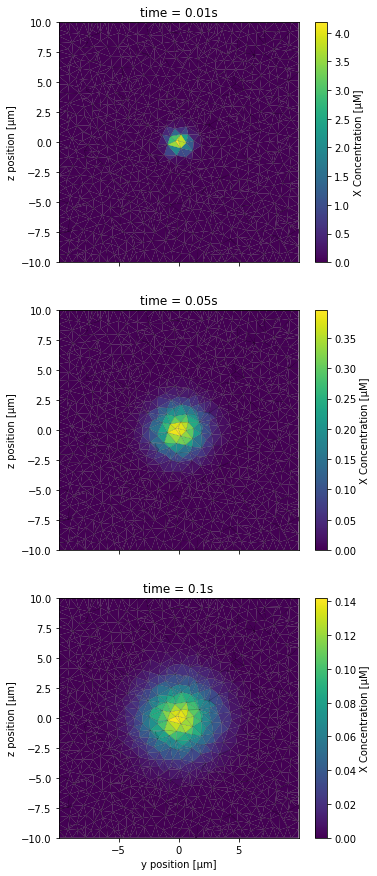

In [24]:
mesh = TetMesh.LoadAbaqus('meshes/cylinder_86k.inp', 1e-6)

XCountSlice = ResultSelector.FromFile('XCountSlice.dat')

tinds = np.linspace(1, len(XCountSlice.time[0]) - 1, 3).astype(int)
proj = np.array([
    [0, 1e6, 0],
    [0, 0, 1e6]
])
xlbl = 'y position [μm]'
ylbl = 'z position [μm]'
clbl = 'X Concentration [μM]'

PlotSliceConc(XCountSlice, 0, NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

The x axis of the plot corresponds to the y axis of the full 3D space and the y axis of the plot to the z axis of the 3D space; we scale all distances to μm. Note that each subplot has its own color scale because the maximum concentrations at t = 0.01s are much higher than for the other time points and a single color scale would prevent seeing the concentration gradients on the 3 other subplots.

We next create the same plots but for the scenario in which we prevented diffusion across the z = 0 plane:

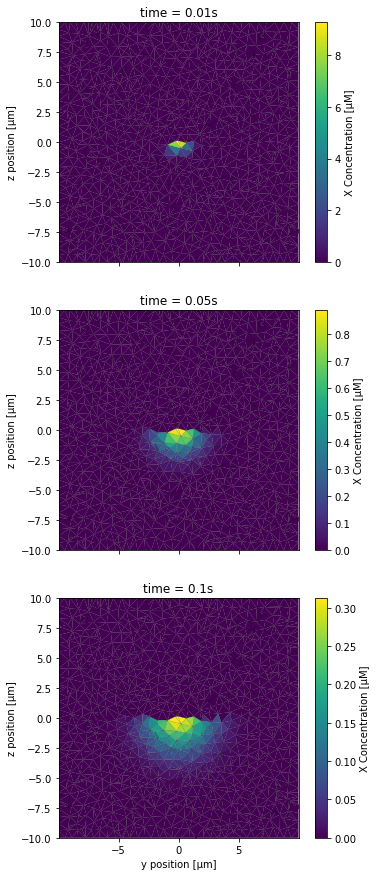

In [25]:
PlotSliceConc(XCountSlice, NBRUNS, 2*NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

As expected, one half of the slice did not receive any species `X`. Finally, we take a look at the scenario in which the diffusion boundary restricted diffusion to a tenth of its original value:

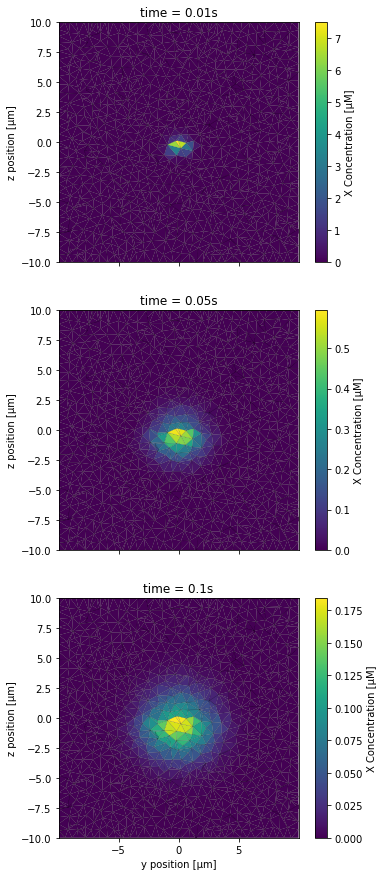

In [26]:
PlotSliceConc(XCountSlice, 2*NBRUNS, 3*NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

We now would like to make the same types of plots but for the surface diffusion boundary data. We first need to define a helper function that is similar to `PlotSliceConc` but simpler since the data we recorded is directly associted to each triangles of the top surface of the cylinder. We thus define `PlotPatchConc` as:

In [27]:
def PlotPatchConc(results, runStart, runEnd, mesh, tinds, proj, xlabel, ylabel, clabel):
    fig = plt.figure(figsize=(6, 15))
    
    for i, tind in enumerate(tinds):
        ax = fig.add_subplot(len(tinds), 1, i+1)
        ax.set_aspect("equal")

        triangles = TriList([ind for ind in results.metaData['loc_id']], mesh=mesh)
        values = np.mean(results.data[runStart:runEnd, tind, :], axis=0)
        values /= results.metaData['triArea'] * 1e-12
        
        PlotProjectedSurface(fig, ax, triangles, values, proj, xlabel, ylabel, clabel)
        
        ax.set_title(f'time = {results.time[0][tind]}s')
        if i < len(tinds) - 1:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    plt.show()

For each time point, we first create the list of triangles. Note that this time we did not explicitely save the index of each triangles as metadata when we declared our `ResultSelector`, instead we use automatically declared metadata `'loc_id'` that contains the identifiers of the geometrical location for which the data is saved. If this location is a patch or a compartment, this will contain its name, if it is a tetrahedron or a triangle, it will contain its index in the mesh. The following metadata are automatically declared for all `ResultSelector`s:

Metadata key | Description | Value
:-- | :-- | :--
`'loc_type'` | Geometrical location type | `'Tet'` for tetrahedrons, `'Tri'` for triangles, `'Patch'` for patches, etc.
`'loc_id'` | Identifier of geometrical location | Name for patches or compartment, mesh index for tetrahedrons or triangles
`'parent_loc_type'` | Parent geometrical location type | Only defined for tetrahedrons and triangles, type of the compartment or patch to which the element is associated, if any
`'parent_loc_id'` | Parent identifier | Only defined for tetrahedrons and triangles, name of the compartment or patch to which the element is associated, if any
`'obj_type'` | Object type | `'Species'` for species, `'Reaction'` for reactions, etc.
`'obj_id'` | Object identifier | Name of species, reaction, etc.

Note that we have to specify the mesh explicitely when creating the `TriList` since we are not in a `with mesh:` block. The values associated to each triangle are then computed and scaled to be expressed in $\mathrm{\mu m}^{-2}$. The triangles are plotted using the first helper function we defined. All that is left to do now is to specify the referential in which the triangles should be projected and to load the data. We will first do so for the unconstrained surface diffusion scenario:

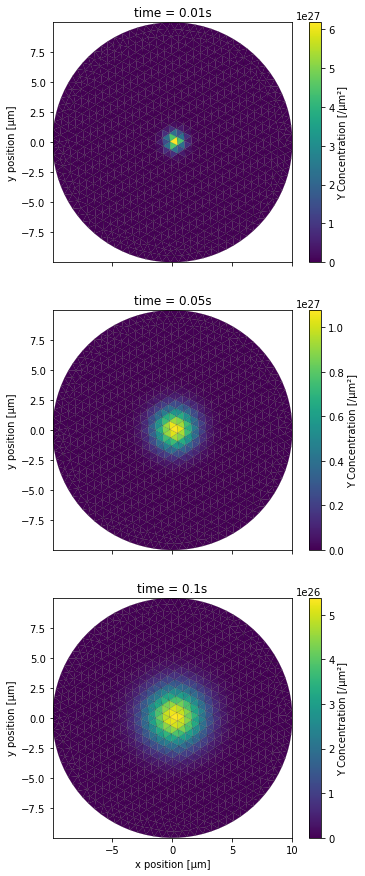

In [28]:
proj = np.array([
    [1e6, 0, 0],
    [0, 1e6, 0]
])
xlbl = 'x position [μm]'
ylbl = 'y position [μm]'
clbl = 'Y Concentration [/μm²]'

YCountPatch = ResultSelector.FromFile('YCountPatch.dat')
PlotPatchConc(YCountPatch, 0, NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

This time we wanted to have a top down view of the top surface of the cylinder. Both the x and y axes of the plot thus correspond to the x and y axes of the 3D space, with distances being scaled to μm. We then create the same plots for the 2 remaining scenarios. First for the completely blocking diffusion boundary scenario:

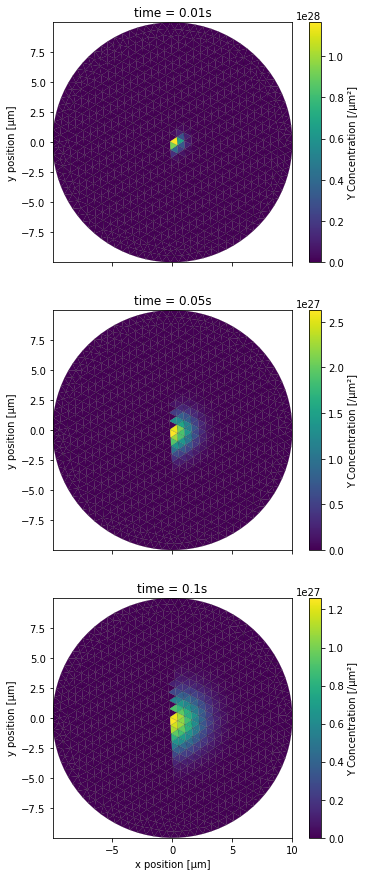

In [29]:
PlotPatchConc(YCountPatch, NBRUNS, 2*NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

Then for the partially blocking one:

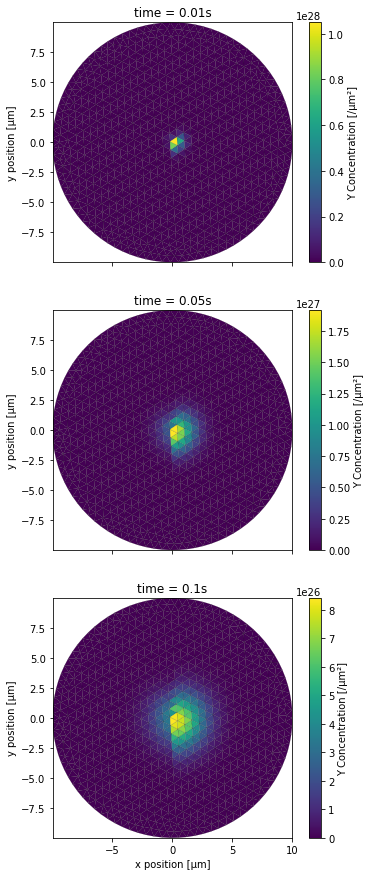

In [30]:
PlotPatchConc(YCountPatch, 2*NBRUNS, 3*NBRUNS, mesh, tinds, proj, xlbl, ylbl, clbl)

### Directional diffusion

In this chapter we saw how to change a diffusion constant with the `Dcst` property. For example, we changed the diffusion constant of the diffusion boundary `diffb` with `sim.diffb.X.Dcst = DCST / 10`. `diffb` sits between `comp1` and `comp2` and the diffusion constant applies to both diffusion from `comp1` to `comp2` and diffusion from `comp2` to `comp1`. STEPS also allows to set the diffusion constant for a specific direction with e.g.:
```python
sim.diffdb(direc=comp2).SA.Dcst = DCST / 2
sim.diffdb(direc=comp1).SA.Dcst = 0
```
With this code, we set the diffusion of `SA` from `comp1` to `comp2` to be `DCST / 2` and we suppress diffusion of `SA` from `comp2` to `comp1`. Note that we use parentheses to further specify `sdiffdb` in the simulation path.

The same thing can be done at the level of tetrahedrons:
```python
sim.TET(tet1).volDiff(direc=tet2).D = DCST / 10
```
Assuming that we named a volume diffusion rule `volDiff`, the above code sets the diffusion constant from `tet1` to `tet2` (which need to be neighboring tetrahedrons in the same compartment). Note that we do not need to specify the species to which this applies since it is already specified in the `volDiff` diffusion rule.

Similarly, for surface diffusion rules and triangles:
```python
sim.TRI(tri1).surfDiff(direc=tri2).D = SDCST / 10
```
Like for tetrahedrons, `tri1` and `tri2` need to be neighboring triangles in the same patch.